In [1]:
%matplotlib inline
import numpy as np
#from chamferdist import ChamferDistance
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from path import Path
#import plyfile as ply
from plyfile import PlyData, PlyElement

import sys
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

import shutil
import urllib
import urllib.request
import tarfile

import random
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px
import copy

from scipy.spatial import ConvexHull, convex_hull_plot_2d


In [2]:
def read_pt(filepath):
    #print(filepath)
    full_pointcloud = torch.load(filepath)
    full_pointcloud= full_pointcloud.T
    return full_pointcloud

In [3]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig
    
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
#         norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
#         norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

#         return  norm_pointcloud
        return pointcloud

In [4]:
def plot_3D(xs,ys,zs):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(121, projection='3d')
    #ax.scatter(xss, yss, zss, c='r')
    ax.scatter(xs, ys, zs)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_zlim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)


    plt.show()

In [5]:
def new_normalize(pointcloud_orig, pointcloud_test):
    assert len(pointcloud_orig.shape)==2
    a= np.mean(pointcloud_orig, axis=0) 
    norm_pointcloud_orig = pointcloud_orig - a
    b= np.max(np.linalg.norm(norm_pointcloud_orig, axis=1))
    norm_pointcloud_orig /= b
    norm_pointcloud_test = pointcloud_test - a
    norm_pointcloud_test /= b
    return  norm_pointcloud_orig, norm_pointcloud_test
    #return pointcloud

def getDirNum(num):
    l= len(str(num))
    return '0'*(3-l) +str(num)

def load_test_data(path,c, category, epoch, example):
    if len(str(epoch))>4:
      n= str(epoch)
    else:
      n= '0'*(3-len(str(epoch)))+str(epoch)
    y= '0'*(3-len(str(category)))+str(category)
    #path+ bathtub/bathtub_000/coordinates/bathtub_000_300_2_recon_coord.pt
    coordinates = torch.load(path+c+'/'+c+'_'+y+'/coordinates/'+c+'_'+y+'_'+n+'_'+str(example)+'_'+'recon_coord.pt')
    coordinates= coordinates.T
    coordinates= Normalize()(coordinates)
    sampled_coordinates= np.asarray([coordinates[np.random.choice(len(coordinates), size=1024, replace=False)]])
    labels= torch.from_numpy(np.asarray([int(category)]))
    return sampled_coordinates, labels


def load_orig_data(c, category):
#     if len(str(epoch))>4:
#       n= str(epoch)
#     else:
#       n= '0'*(3-len(str(epoch)))+str(epoch)
#     y= '0'*(3-len(str(category)))+str(category)
    
    folder_path=  '/home/ubuntu/3d-point-clouds-HyperCloud/3d_point_cloud/dataset/shapenet_training_no_noise/'

    filepath= folder_path+c+'/'+c+'_'+getDirNum(category)+'/'+c+'_'+getDirNum(category)+'.pt'
    pointcloud= read_pt(filepath).T
    coordinates= Normalize()(pointcloud)
    sampled_coordinates= np.asarray([coordinates[np.random.choice(len(coordinates), size=1024, replace=False)]])
    labels= torch.from_numpy(np.asarray([int(category)]))
    
    return sampled_coordinates, labels

# calculating 3D bbox IOU

In [22]:
# 3D IoU caculate code for 3D object detection 
# Kent 2018/12

import numpy as np
from scipy.spatial import ConvexHull
from numpy import *

def polygon_clip(subjectPolygon, clipPolygon):
   """ Clip a polygon with another polygon.
   Ref: https://rosettacode.org/wiki/Sutherland-Hodgman_polygon_clipping#Python
   Args:
     subjectPolygon: a list of (x,y) 2d points, any polygon.
     clipPolygon: a list of (x,y) 2d points, has to be *convex*
   Note:
     **points have to be counter-clockwise ordered**
   Return:
     a list of (x,y) vertex point for the intersection polygon.
   """
   def inside(p):
      return(cp2[0]-cp1[0])*(p[1]-cp1[1]) > (cp2[1]-cp1[1])*(p[0]-cp1[0])
 
   def computeIntersection():
      dc = [ cp1[0] - cp2[0], cp1[1] - cp2[1] ]
      dp = [ s[0] - e[0], s[1] - e[1] ]
      n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
      n2 = s[0] * e[1] - s[1] * e[0] 
      n3 = 1.0 / (dc[0] * dp[1] - dc[1] * dp[0])
      return [(n1*dp[0] - n2*dc[0]) * n3, (n1*dp[1] - n2*dc[1]) * n3]
 
   outputList = subjectPolygon
   cp1 = clipPolygon[-1]
 
   for clipVertex in clipPolygon:
      cp2 = clipVertex
      inputList = outputList
      outputList = []
      s = inputList[-1]
 
      for subjectVertex in inputList:
         e = subjectVertex
         if inside(e):
            if not inside(s):
               outputList.append(computeIntersection())
            outputList.append(e)
         elif inside(s):
            outputList.append(computeIntersection())
         s = e
      cp1 = cp2
      if len(outputList) == 0:
          return None
   return(outputList)

def poly_area(x,y):
    """ Ref: http://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def convex_hull_intersection(p1, p2):
    """ Compute area of two convex hull's intersection area.
        p1,p2 are a list of (x,y) tuples of hull vertices.
        return a list of (x,y) for the intersection and its volume
    """
    inter_p = polygon_clip(p1,p2)
    if inter_p is not None:
        hull_inter = ConvexHull(inter_p)
        return inter_p, hull_inter.volume
    else:
        return None, 0.0  

def box3d_vol(corners):
    ''' corners: (8,3) no assumption on axis direction '''
    a = np.sqrt(np.sum((corners[0,:] - corners[1,:])**2))
    b = np.sqrt(np.sum((corners[1,:] - corners[2,:])**2))
    c = np.sqrt(np.sum((corners[0,:] - corners[4,:])**2))
    return a*b*c

def is_clockwise(p):
    x = p[:,0]
    y = p[:,1]
    return np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)) > 0

def box3d_iou(corners1, corners2):
    ''' Compute 3D bounding box IoU.
    Input:
        corners1: numpy array (8,3), assume up direction is negative Y
        corners2: numpy array (8,3), assume up direction is negative Y
    Output:
        iou: 3D bounding box IoU
        iou_2d: bird's eye view 2D bounding box IoU
    todo (kent): add more description on corner points' orders.
    '''
    # corner points are in counter clockwise order
    rect1 = [(corners1[i,0], corners1[i,2]) for i in range(3,-1,-1)]
    rect2 = [(corners2[i,0], corners2[i,2]) for i in range(3,-1,-1)] 
    
    area1 = poly_area(np.array(rect1)[:,0], np.array(rect1)[:,1])
    area2 = poly_area(np.array(rect2)[:,0], np.array(rect2)[:,1])
   
    inter, inter_area = convex_hull_intersection(rect1, rect2)
    iou_2d = inter_area/(area1+area2-inter_area)
    ymax = min(corners1[0,1], corners2[0,1])
    ymin = max(corners1[4,1], corners2[4,1])

    inter_vol = inter_area * max(0.0, ymax-ymin)
    
    vol1 = box3d_vol(corners1)
    vol2 = box3d_vol(corners2)
    iou = inter_vol / (vol1 + vol2 - inter_vol)
    return iou, iou_2d

# ----------------------------------
# Helper functions for evaluation
# ----------------------------------

def get_3d_box(box_size, heading_angle, center):
    ''' Calculate 3D bounding box corners from its parameterization.
    Input:
        box_size: tuple of (length,wide,height)
        heading_angle: rad scalar, clockwise from pos x axis
        center: tuple of (x,y,z)
    Output:
        corners_3d: numpy array of shape (8,3) for 3D box cornders
    '''
    def roty(t):
        c = np.cos(t)
        s = np.sin(t)
        return np.array([[c,  0,  s],
                         [0,  1,  0],
                         [-s, 0,  c]])

    R = roty(heading_angle)
    l,w,h = box_size
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2];
    y_corners = [h/2,h/2,h/2,h/2,-h/2,-h/2,-h/2,-h/2];
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2];
    corners_3d = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    corners_3d[0,:] = corners_3d[0,:] + center[0];
    corners_3d[1,:] = corners_3d[1,:] + center[1];
    corners_3d[2,:] = corners_3d[2,:] + center[2];
    corners_3d = np.transpose(corners_3d)
    return corners_3d

    
if __name__=='__main__':
    print('------------------')
    # get_3d_box(box_size, heading_angle, center)
    corners_3d_ground  = get_3d_box((1.497255,1.644981, 3.628938), -1.531692, (2.882992 ,1.698800 ,20.785644)) 
    corners_3d_predict = get_3d_box((1.458242, 1.604773, 3.707947), -1.549553, (2.756923, 1.661275, 20.943280 ))
    print(corners_3d_ground, corners_3d_predict)
    (IOU_3d,IOU_2d)=box3d_iou(corners_3d_predict,corners_3d_ground)
    print (IOU_3d,IOU_2d) #3d IoU/ 2d IoU of BEV(bird eye's view)

------------------
[[ 2.09039739  3.513269   21.56585393]
 [ 3.73412084  3.513269   21.50154445]
 [ 3.67558661  3.513269   20.00543407]
 [ 2.03186316  3.513269   20.06974355]
 [ 2.09039739 -0.115669   21.56585393]
 [ 3.73412084 -0.115669   21.50154445]
 [ 3.67558661 -0.115669   20.00543407]
 [ 2.03186316 -0.115669   20.06974355]] [[ 1.97020533  3.5152485  21.68928056]
 [ 3.57461625  3.5152485  21.65519241]
 [ 3.54364067  3.5152485  20.19727944]
 [ 1.93922975  3.5152485  20.23136759]
 [ 1.97020533 -0.1926985  21.68928056]
 [ 3.57461625 -0.1926985  21.65519241]
 [ 3.54364067 -0.1926985  20.19727944]
 [ 1.93922975 -0.1926985  20.23136759]]
0.6879605829952761 0.7003692488090808


In [33]:
classes=['bathtub',  'bed',  'bench',  'bookshelf',  'cabinet',  'chair',  'lamp',  'monitor',  'sofa',  'table']
path= '/home/ubuntu/3d-point-clouds-HyperCloud/experiments_arpit/all_intra_class_multiple_epoch_dataset100/'
results=np.zeros((10,100,150))
for j in range(10):
    cls=classes[j]
    for k in range(100):
        print(cls,k)
        reference, reflabels = load_orig_data(cls, k)
        count=0
        for i in range(2,302,2):
            inputs, labels = load_test_data(path,cls, k, i,1)
            #ref,test= new_normalize(reference[0], inputs[0])
            ref,test= reference[0], inputs[0]

            xmin,ymin,zmin,xmax,ymax,zmax= min(ref[:,0]),min(ref[:,1]),min(ref[:,2]),max(ref[:,0]),max(ref[:,1]),max(ref[:,2])
            x2min,y2min,z2min,x2max,y2max,z2max= min(test[:,0]),min(test[:,1]),min(test[:,2]),max(test[:,0]),max(test[:,1]),max(test[:,2])
            corners1=np.asarray([[xmin,ymax,zmax],[xmax,ymax,zmax],[xmax,ymax,zmin],[xmin,ymax,zmin],[xmin,ymin,zmax],[xmax,ymin,zmax],[xmax,ymin,zmin],[xmin,ymin,zmin]])
            corners2=np.asarray([[x2min,y2max,z2max],[x2max,y2max,z2max],[x2max,y2max,z2min],[x2min,y2max,z2min],[x2min,y2min,z2max],[x2max,y2min,z2max],[x2max,y2min,z2min],[x2min,y2min,z2min]])
            #print(corners1, corners2)
            val= box3d_iou(corners1, corners2)[0]
            #print(val)
            results[j][k][count]= val
            count+=1
            #break
        #break
    #break

bathtub 0
bathtub 1
bathtub 2
bathtub 3
bathtub 4
bathtub 5
bathtub 6
bathtub 7
bathtub 8
bathtub 9
bathtub 10
bathtub 11
bathtub 12
bathtub 13
bathtub 14
bathtub 15
bathtub 16
bathtub 17
bathtub 18
bathtub 19
bathtub 20
bathtub 21
bathtub 22
bathtub 23
bathtub 24
bathtub 25
bathtub 26
bathtub 27
bathtub 28
bathtub 29
bathtub 30
bathtub 31
bathtub 32
bathtub 33
bathtub 34
bathtub 35
bathtub 36
bathtub 37
bathtub 38
bathtub 39
bathtub 40
bathtub 41
bathtub 42
bathtub 43
bathtub 44
bathtub 45
bathtub 46
bathtub 47
bathtub 48
bathtub 49
bathtub 50
bathtub 51
bathtub 52
bathtub 53
bathtub 54
bathtub 55
bathtub 56
bathtub 57
bathtub 58
bathtub 59
bathtub 60
bathtub 61
bathtub 62
bathtub 63
bathtub 64
bathtub 65
bathtub 66
bathtub 67
bathtub 68
bathtub 69
bathtub 70
bathtub 71
bathtub 72
bathtub 73
bathtub 74
bathtub 75
bathtub 76
bathtub 77
bathtub 78
bathtub 79
bathtub 80
bathtub 81
bathtub 82
bathtub 83
bathtub 84
bathtub 85
bathtub 86
bathtub 87
bathtub 88
bathtub 89
bathtub 90
bathtub 9

In [34]:
np.save('/home/ubuntu/Pointnet/results/July03/bbox/results3.npy', results)

In [71]:
classes=['bathtub',  'bed',  'bench',  'bookshelf',  'cabinet',  'chair',  'lamp',  'monitor',  'sofa',  'table']
path= '/home/ubuntu/3d-point-clouds-HyperCloud/experiments_arpit/all_intra_class_multiple_epoch_dataset100/'
results=np.zeros((10,100,150))
for j in range(10):
    cls=classes[j]
    for k in range(100):
        print(cls,k)
        reference, reflabels = load_orig_data(cls, k)
        count=0
        for i in range(2,302,2):
            inputs, labels = load_test_data(path,cls, k, i,1)
            ref,test= new_normalize(reference[0], inputs[0])

            x,y,z,x0,y0,z0= max(ref[:,0])-min(ref[:,0]),max(ref[:,1])-min(ref[:,1]),max(ref[:,2])-min(ref[:,2]),(max(ref[:,0])+min(ref[:,0]))/2,(max(ref[:,1])+min(ref[:,1]))/2,(max(ref[:,2])+min(ref[:,2]))/2
            x1,y1,z1,x10,y10,z10= max(test[:,0])-min(test[:,0]),max(test[:,1])-min(test[:,1]),max(test[:,2])-min(test[:,2]),(max(test[:,0])+min(test[:,0]))/2,(max(test[:,1])+min(test[:,1]))/2,(max(test[:,2])+min(test[:,2]))/2

            val= abs(x-x1)*abs(y-y1)*abs(z-z1)+abs(x0-x10)*abs(y0-y10)*abs(z0-z10)
            results[j][k][count]= val
            count+=1

bathtub 0
bathtub 1
bathtub 2
bathtub 3
bathtub 4
bathtub 5
bathtub 6
bathtub 7
bathtub 8
bathtub 9
bathtub 10
bathtub 11
bathtub 12
bathtub 13
bathtub 14
bathtub 15
bathtub 16
bathtub 17
bathtub 18
bathtub 19
bathtub 20
bathtub 21
bathtub 22
bathtub 23
bathtub 24
bathtub 25
bathtub 26
bathtub 27
bathtub 28
bathtub 29
bathtub 30
bathtub 31
bathtub 32
bathtub 33
bathtub 34
bathtub 35
bathtub 36
bathtub 37
bathtub 38
bathtub 39
bathtub 40
bathtub 41
bathtub 42
bathtub 43
bathtub 44
bathtub 45
bathtub 46
bathtub 47
bathtub 48
bathtub 49
bathtub 50
bathtub 51
bathtub 52
bathtub 53
bathtub 54
bathtub 55
bathtub 56
bathtub 57
bathtub 58
bathtub 59
bathtub 60
bathtub 61
bathtub 62
bathtub 63
bathtub 64
bathtub 65
bathtub 66
bathtub 67
bathtub 68
bathtub 69
bathtub 70
bathtub 71
bathtub 72
bathtub 73
bathtub 74
bathtub 75
bathtub 76
bathtub 77
bathtub 78
bathtub 79
bathtub 80
bathtub 81
bathtub 82
bathtub 83
bathtub 84
bathtub 85
bathtub 86
bathtub 87
bathtub 88
bathtub 89
bathtub 90
bathtub 9

In [72]:
np.save('/home/ubuntu/Pointnet/results/July03/bbox/results2.npy', results)

In [57]:
val

0.0024808588780716847

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

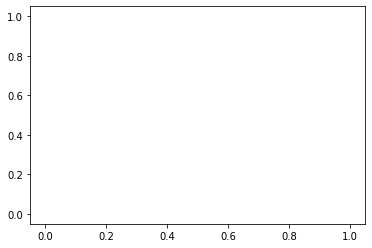

In [24]:
# plt.plot(np.mean(results[0],0))
plt.plot(results[0][1])
results[0][4]

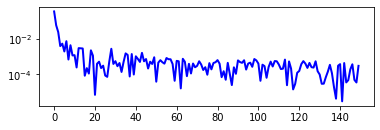

In [62]:
import pylab
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(results[0][0], color='blue', lw=2)

ax.set_yscale('log')

pylab.show()

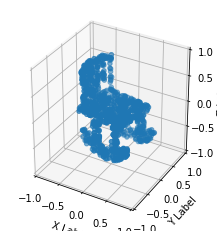

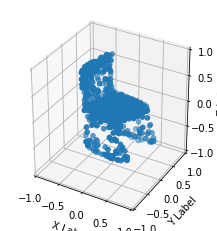

In [47]:
plot_3D(ref[:,0],ref[:,1],ref[:,2])
plot_3D(test[:,0],test[:,1],test[:,2])

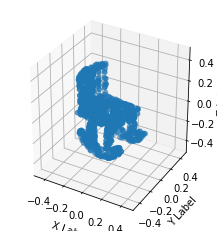

In [20]:
plot_3D(reference[0][:,0],reference[0][:,1],reference[0][:,2])

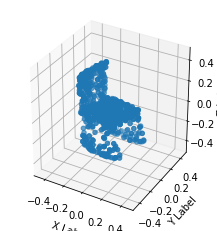

In [22]:
plot_3D(inputs[0][:,0],inputs[0][:,1],inputs[0][:,2])

In [ ]:
classes=['chair',  'table']
classcount=0
results=np.zeros((2,4,151,2))
results=[]
for i in range(2):
    b=[]
    for j in range(4):
        a=[]
        for k in range(151):
            a.append([[],[]])
        b.append(a)
    results.append(b)
    
for c in classes:
    path= '/home/ubuntu/3d-point-clouds-HyperCloud/experiments_arpit/all_intra_class_multiple_epoch_dataset100/'
    print (c)
    for category in range(4): 
        print('Class '+str(category))
        epochs=[]
        count=0
        reference, reflabels = load_orig_data(c, category)
        results[classcount][category][0][0]= reference[0]
        try:
            planePoints1, objpoints1, eq1= get_ransac_planes(reference[0])
            results[classcount][category][0][1]= planePoints1
            for epoch in range(2,302,2): 
                if epoch%100==0:
                    print(epoch,' ',)
                for example in range(1):
                    inputs, labels = load_test_data(path,c, category, epoch,example)
                    results[classcount][category][count+1][0]= inputs[0]
                    try:
                        planePoints2, objpoints2, eq2= get_ransac_planes(inputs[0])
                        results[classcount][category][count+1][1]= planePoints2
                    except:
                        pass

                count+=1
                #break
        except:
            pass
    classcount+=1
                
    #np.save('/home/ubuntu/Pointnet/results/July03/ransac/'+c+'.npy', results)